# Challenge B: Fit an experimental TDS spectrum

## Description

A $20 \ \mathrm{\mu m}$ thick sample of tungsten was damaged with high energy ions.
We estimate the damage region to be $1 \ \mathrm{\mu m}$ where defects were created.

After the damaging phase, the sample was exposed to energetic D ions for $2000 \ \mathrm{s}$ at an incident flux of $5 \ \times 10^{19} \ \mathrm{D \ m^{-2} \ s^{-1} }$ at a temperature $T_\mathrm{exp} \in [300, 400, 500] \ \mathrm{K}$.
We will assume that the implantation follows a gaussian distribution with a mean of $5 \mathrm{nm}$ and a standard deviation of $2.1 \ \mathrm{\mu m}$. Moreover, we will assume a reflection coefficient of $0.5$ (ie. only half the incident ions are implanted).

The sample was then stored for approximately $50 \ \mathrm{s}$ at $300 \ \mathrm{K}$. After the storage period, Nuclear Reaction Analysis (NRA) was performed to measure the total D concentration profile in the sample up to $5 \ \mathrm{\mu m}$.

The sample's temperature was then increased linearly with a ramp of $4 \ \mathrm{K/s}$ up to $700 \ \mathrm{K}$ and the desorption flux was measured.

**📖 Task: find the set of trapping parameters that reproduce the experimental measurements.
You don't have to simulate the damaging phase.**

💡Hint: the damage phase has created traps in the damaged region.

## Experimental data

You have access to the experimental TDS measurement and NRA profiles at each exposure temperature.
They are stored in ``challenge_B`` directory. Each subdirectory contains two txt files ``retention_profile.txt`` and ``tds.txt``.


💡 Here are two plotting functions you can use later to plot the experimental data and compare it to your FESTIM script.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def plot_experimental_tds(T_exp, **kwargs):
    data = np.genfromtxt(f"challenge_B/{T_exp}_K/tds.txt", skip_header=1, delimiter=",")
    flux = data[:, -1]
    tds_T = data[:, 1]
    return plt.plot(tds_T, flux, **kwargs)


def plot_nra_profile(T_exp, **kwargs):
    data = np.genfromtxt(
        f"challenge_B/{T_exp}_K/retention_profile.txt", skip_header=1, delimiter=","
    )
    depth = data[:, 0]
    nra = data[:, 1]
    return plt.step(depth, nra, **kwargs)

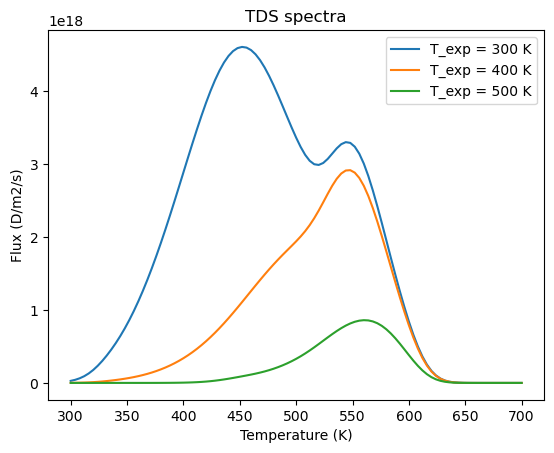

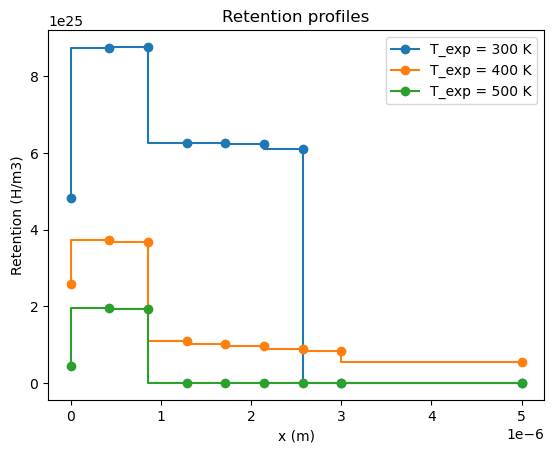

In [2]:
exposure_temps = [300, 400, 500]  # K

for T_exp in exposure_temps:
    plot_experimental_tds(T_exp, label=f"T_exp = {T_exp} K")

plt.title("TDS spectra")
plt.xlabel("Temperature (K)")
plt.ylabel("Flux (D/m2/s)")
plt.legend()
plt.show()

for T_exp in exposure_temps:
    plot_nra_profile(T_exp, label=f"T_exp = {T_exp} K", marker="o")

plt.title("Retention profiles")
plt.xlabel("x (m)")
plt.ylabel("Retention (H/m3)")
plt.legend()
plt.show()

In [2]:
import h_transport_materials as htm

# tungsten properties
diffusivity_tungsten = htm.diffusivities.filter(
    material=htm.TUNGSTEN, author="frauenfelder"
)[0]
print(f"Diffusivity of tungsten: \n {diffusivity_tungsten}")

Diffusivity of tungsten: 
 
        Author: Frauenfelder
        Material: tungsten
        Year: 1969
        Isotope: H
        Pre-exponential factor: 4.10×10⁻⁷ m²/s
        Activation energy: 3.90×10⁻¹ eV/particle
        


## Your answer

In [3]:
implantation_time = 2000  # s
temperature_ramp = 4  # K/s

storage_time = 50  # s
storage_temp = 300  # K

start_tds = implantation_time + storage_time  # s  DON'T RENAME THIS

import festim as F


def festim_model(T_exp):
    """Runs a festim model and returns the derived quantities

    Args:
        T_exp (float): exposure temperature in K

    Returns:
        F.DerivedQuantities: the derived quantities
    """

    # YOUR CODE GOES HERE ...

    derived_quantities = F.DerivedQuantities()

    # ------- YOUR CODE ENDS HERE -------
    return derived_quantities

Here are two plotting functions to plot a simulated TDS spectrum and a simulated retention profile.

In [4]:
def plot_simulated_tds(derived_quantities, **kwargs):
    """Function to plot a simulated TDS spectrum

    Args:
        derived_quantities (festim.DerivedQuantities): the derived quantities object from the simulation.
            Assumes we have an AverageVolume(field="T") and two SurfaceFlux(fields="solute") for surfaces 1 and 2.
        **kwargs: keyword arguments to be passed to the plot function.
    """
    if derived_quantities == []:
        return
    t = np.array(derived_quantities.t)
    indexes = np.where(t >= start_tds)[0]
    temp = np.array(derived_quantities.filter(fields="T").data)
    flux_left = np.array(derived_quantities.filter(fields="solute", surfaces=1).data)
    flux_right = np.array(derived_quantities.filter(fields="solute", surfaces=2).data)

    flux_total = -flux_left - flux_right

    temp = temp[indexes]
    flux_total = flux_total[indexes]
    t = t[indexes]

    return plt.plot(temp, flux_total, **kwargs)


def plot_simulated_profile(filename: str = "", **kwargs):
    if filename == "":
        return
    data_retention = np.genfromtxt(filename, delimiter=",", skip_header=1)
    return plt.plot(data_retention[:, 0], data_retention[:, 1], **kwargs)

We will store all the model results in a dictionary ``T_exp_to_derived_quantities`` to be able to retrieve them later.

In [5]:
T_exp_to_derived_quantities = {}

for T_exp in exposure_temps:
    print(f"Running for {T_exp} K")
    derived_quantities = festim_model(T_exp)
    T_exp_to_derived_quantities[T_exp] = derived_quantities

Running for 300 K
Running for 400 K
Running for 500 K


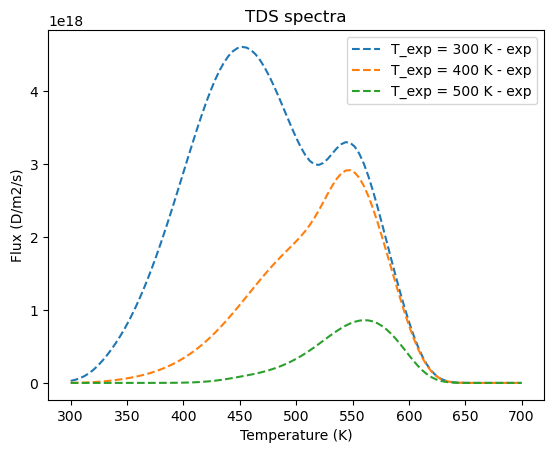

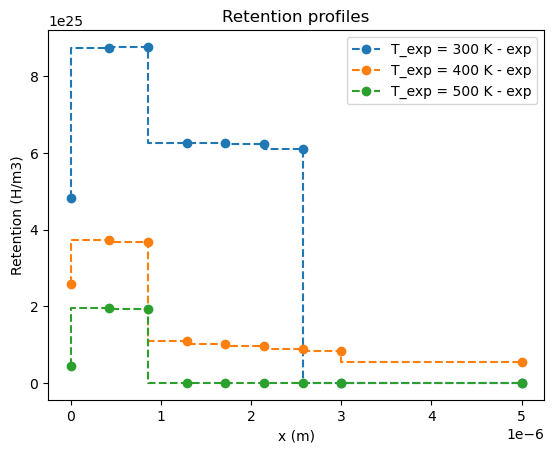

In [6]:
for T_exp in exposure_temps:

    derived_quantities = T_exp_to_derived_quantities[T_exp]

    plt.figure(1)
    (l,) = plot_experimental_tds(
        T_exp, label=f"T_exp = {T_exp} K - exp", linestyle="dashed"
    )
    plot_simulated_tds(
        derived_quantities=derived_quantities, color=l.get_color(), label=f"FESTIM"
    )

    plt.figure(2)
    filename = ""  # CHANGE THIS
    (l,) = plot_nra_profile(
        T_exp, label=f"T_exp = {T_exp} K - exp", linestyle="dashed", marker="o"
    )
    plot_simulated_profile(filename, color=l.get_color(), label=f"FESTIM")

plt.figure(1)
plt.title("TDS spectra")
plt.xlabel("Temperature (K)")
plt.ylabel("Flux (D/m2/s)")
plt.legend()

plt.figure(2)
plt.title("Retention profiles")
plt.xlabel("x (m)")
plt.ylabel("Retention (H/m3)")
plt.legend()

plt.show()